# COVID-19 Vaccine Forecast

## Part 3 - Preprocessing

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

from keras import backend as K

from math import sqrt
import time
import os
import joblib
import random

In [2]:
# create function that sets OS `PYTHONHASHSEED` environment variable,
# Python, NumPy, and TensorFlow seeds at a fixed value
def reset_seeds():
    os.environ['PYTHONHASHSEED']=str(42)
    random.seed(42)
    np.random.seed(42)
    set_random_seed(42)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

reset_seeds()

2022-09-13 16:59:14.558871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# read in clean massachussets data into a pandas dataframe
df = pd.read_csv('../data/massachusetts_vaccinations_09_04_21_clean.csv')

### Persistence Model Baseline

A good baseline forecast for a time series with a linear increasing trend is a persistence forecast. The observation from the prior time step (t-1) will be used to predict the observation at current time step (t).

In [4]:
# convert feature of interest to a numpy array 
data = df['total_vaccinations'].values

# split data into train and test
train, test = data[:-7], data[-7:]

# create column for lagged data
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    predictions.append(history[-1])
    history.append(test[i])

In [5]:
# calculate room mean square error
rmse = sqrt(mean_squared_error(test, predictions))
print(F'RMSE: {rmse}')

RMSE: 12900.249388508515


In [6]:
# create function for MAPE
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual-pred)/actual))*100

In [7]:
# calculate MAPE of test values and persistence model baseline predictions
pmb_mape = mape(test, predictions)
print(F'MAPE percentage: {round(pmb_mape, 2)}%')

MAPE percentage: 0.13%


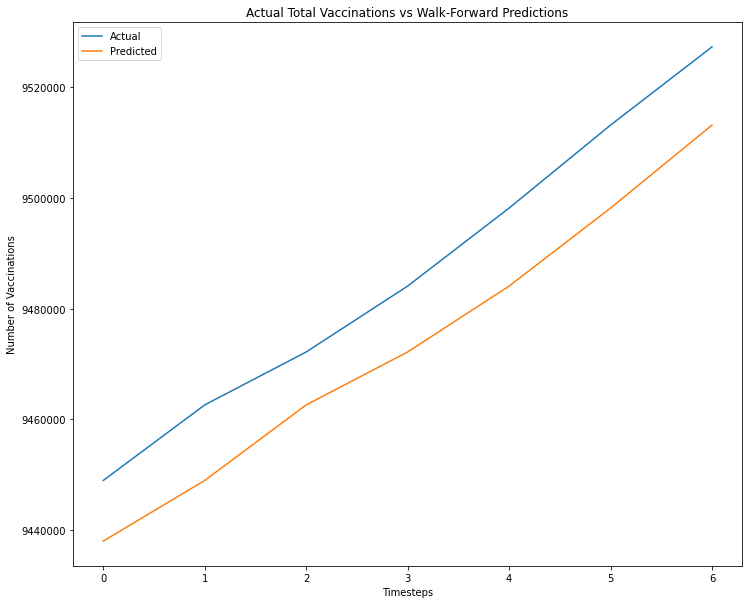

In [8]:
# plot graph of test actual (t) vs test predicted (t-1) for persistence model forecast
fig, ax = plt.subplots(figsize=(12,10))

ax.yaxis.get_major_formatter().set_scientific(False)
plt.title('Actual Total Vaccinations vs Walk-Forward Predictions')
plt.plot(test,label="Actual")
plt.plot(predictions,label="Predicted")
plt.xlabel('Timesteps')
plt.ylabel('Number of Vaccinations')
plt.legend()
plt.show()

A model must have a lower RMSE than the walk forward validation model to be considered useful.

### LSTM GridSearch Preprocessing

In [9]:
# convert feature of interest to a single df column
data = df[['total_vaccinations']]

In [10]:
# define function that fits minmaxscaler on train data and
# and transforms both train and test data
# scaler is pickled in order to inverse_transform values later
def data_normalization(data, test_window):
    train_data = data[:test_window]
    test_data = data[test_window:]
    scaler = MinMaxScaler()
    train_sc = scaler.fit_transform(train_data)
    test_sc = scaler.transform(test_data)
    joblib.dump(scaler, '../data/scaler_1.pkl')
    data_sc = np.append(train_sc, test_sc)
    return data_sc

In [11]:
# set length of test window
test_window = len(data)-7

# run data through data normalization function
data_sc = data_normalization(data, test_window)

In [12]:
# create function that separates data into X and y
# each X value is an array whose length is specified by the "n_steps" argument
def sampling(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):     
        sam = i + n_steps
        if sam > len(sequence)-1:
            break
        x, Y = sequence[i:sam], sequence[sam]
        X.append(x)
        y.append(Y)
    return np.array(X), np.array(y)

In [13]:
# specify number of steps
n_steps = 1

# run data through the sampling function
X, y = sampling(data_sc, n_steps)

In [14]:
# check shape of X and Y
X.shape, y.shape

((234, 1), (234,))

In [15]:
# set size of test window
test_window = len(X)-7

# split X and y into train and test
X_train, y_train = X[:test_window], y[:test_window]
X_test, y_test = X[test_window:], y[test_window:]

#convert data into suitable dimension for using it as input in LSTM network
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(227, 1, 1) (227, 1) (7, 1, 1) (7, 1)


In [16]:
# assign input shape for LSTM gridsearch
input_shape = (X_train.shape[1], X_train.shape[2])
# check input shape
input_shape

(1, 1)

### Gridsearching
#### Tuning neurons 

The gridsearches are commented out so that they don't get rerun when the notebook is run
GridSearched results were pickled for further use
Gridsearch took 2068 seconds to execute
TimeSeriesSplit is used as the form of crossvalidation because it's more appropriate than using k-folds crossvalidation

In [17]:
# # Create lstm function to gridsearch
# def model_lstm_simple(hidden_neurons=1, learning_rate=.001):
#     model = Sequential()
    
#     model.add(LSTM(hidden_neurons, input_shape=input_shape))
#     model.add(Dense(1))

#     model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate), metrics=['mae'])
    
#     return model

# # The params grid:
# nn_params_deep = {'hidden_neurons':[1, 2, 4, 8],
#                   'epochs':[25, 50, 100],
#                   'learning_rate': [.001, .0005, .0001]
#                  }
# nn = KerasRegressor(build_fn=model_lstm_simple, batch_size=1, epochs=25, verbose=0, shuffle=False)

# gs_1 = GridSearchCV(estimator=nn, param_grid=nn_params_deep, cv=TimeSeriesSplit(n_splits=3, test_size=7).split(X_train))  
# start_time = time.time()
# gs_1.fit(X_train, y_train)
# print(f'Function took {time.time() - start_time} seconds to run')
# print(gs_1.best_score_)
# gs_1.best_params_

In [18]:
# # pickle best gridsearch parameters
# joblib.dump(gs_1.best_params_, "../data/gs_1.pkl")

#### Tuning dropout and batch size

Because dropout withholds a certain amount of neurons from the network, I'm going to gridsearch a higher number of neurons to compensate for the dropout so that the model doesn't get too simplistic and underfit.

In [19]:
# # Gridsearch for dropout and batch_size
# def model_dropout_batch(hidden_neurons=8, dropout =.08):
#     model = Sequential()
    
#     model.add(LSTM(hidden_neurons, input_shape=input_shape))
#     model.add(Dropout(dropout))
#     model.add(Dense(1))

#     model.compile(loss='mse', optimizer=Adam(learning_rate=0.0005), metrics=['mae'])
    
#     return model

# # The params grid:
# nn_params_deep = {'hidden_neurons':[8, 10, 16, 32],
#                   'dropout':[.8, .9],
#                   'batch_size': [1, 2, 4]
#                  }
# nn = KerasRegressor(build_fn=model_dropout_batch, batch_size=1, epochs=50, verbose=0, shuffle=False)

# gs_2 = GridSearchCV(estimator=nn, param_grid=nn_params_deep, cv=TimeSeriesSplit(n_splits=3, test_size=7).split(X_train))  
# start_time = time.time()
# gs_2.fit(X_train, y_train)
# print(f'Function took {time.time() - start_time} seconds to run')
# print(gs_2.best_score_)
# gs_2.best_params_

In [20]:
# # pickle gridsearch paramaters
# joblib.dump(gs_2.best_params_, "../data/gs_2.pkl")

#### Tuning for neurons and learning_rate

I'm going to gridsearch a higher number of neurons than gridsearch_1, as well as gridsearch different learning rates to see how it influences stochastic gradient descent and thus how well my model performs.

In [21]:
# # Gridsearch for neurons and learning_rate
# def model_dropout_lr(hidden_neurons=32, dropout =.08, learning_rate=0.001):
#     model = Sequential()
    
#     model.add(LSTM(hidden_neurons, input_shape=input_shape))
#     model.add(Dropout(dropout))
#     model.add(Dense(1))

#     model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate), metrics=['mae'])
    
#     return model

# # The params grid:
# nn_params_deep = {'hidden_neurons':[32, 64, 128],
#                   'dropout':[.8, .9],
#                   'learning_rate':[0.001, 0.0005, 0.0001]
#                  }
# nn = KerasRegressor(build_fn=model_dropout_lr, batch_size=1, epochs=50, verbose=0, shuffle=False)

# gs_3 = GridSearchCV(estimator=nn, param_grid=nn_params_deep, cv=TimeSeriesSplit(n_splits=3, test_size=7).split(X_train))  
# start_time = time.time()
# gs_3.fit(X_train, y_train)
# print(f'Function took {time.time() - start_time} seconds to run')
# print(gs_3.best_score_)
# gs_3.best_params_

In [22]:
# # pickle gridsearch parameters
# joblib.dump(gs_3.best_params_, "../data/gs_3.pkl")